In [1]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import pydicom 
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
from torch.utils.data import random_split
import cv2
import model as modelzoo

In [2]:
pathology = 'scs'
df = pd.read_csv("../dataframes/" + pathology + "_train.csv")
df['label'].value_counts()

label
0.0    8552
1.0     732
2.0     469
Name: count, dtype: int64

In [3]:
class_counts = {0: 8552, 1: 732, 2: 469}

# Calculate weights
total_samples = sum(class_counts.values())
num_classes = len(class_counts)
weights = {class_id: total_samples / (num_classes * count) for class_id, count in class_counts.items()}

# Normalize weights
weight_sum = sum(weights.values())
weights = {class_id: weight / weight_sum for class_id, weight in weights.items()}

# Convert to PyTorch tensor
class_weights = torch.FloatTensor([weights[0], weights[1], weights[2]])
guess_weights = torch.FloatTensor([1, 5, 3])

print("Class weights:", class_weights)

Class weights: tensor([0.0323, 0.3779, 0.5898])


In [8]:
class SpinalStenosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        if isinstance(annotations_file, str):
            self.img_labels = pd.read_csv(annotations_file)
        elif isinstance(annotations_file, pd.DataFrame):
            self.img_labels = annotations_file
        else:
            raise TypeError("annotations_file must be a CSV file path or a pandas DataFrame")
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        row = self.img_labels.iloc[idx]
        # img_path = os.path.join(self.img_dir, f"{row['study_id']}/{row['series_id']}/{row['instance_number']}.dcm")
        # image, x_scale, y_scale = self.read_dicom_image(img_path)
        image, x_scale, y_scale = self.read_dicom_imagesss(self.img_dir,row['study_id'],row['series_id'], row['instance_number'])

        
        # Apply Z-score normalization before cropping
#         image = self.z_score_normalize(image)
        
        x, y = row['x'], row['y']
        image = self.crop_to_bounding_box(image, x, y, x_scale, y_scale)
        
        if self.transform:
            image = self.transform(image)
        
        label = row['label']
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

    def read_dicom_image(self, path):
        dicom = pydicom.dcmread(path)
        image = dicom.pixel_array
        image = image.astype(np.float32) 
        image = (image - image.min())/(image.max() - image.min())
        y_scale,x_scale = 512/image.shape[0], 512/image.shape[1]
        image = cv2.resize(image, (512,512))
        image = torch.from_numpy(image).unsqueeze(0)  # Add channel dimension
        image = image.repeat(3, 1, 1)  # Repeat the single channel image three times
        return image, x_scale, y_scale
    
    def read_dicom_imagesss(self, path, study_id,series_id, instance):
        instance_numbers = [instance-1, instance, instance+1]
        images = []
        for i in instance_numbers:
            img_path = os.path.join(path, f"{study_id}/{series_id}/{i}.dcm")
            if os.path.exists(img_path):
                dicom = pydicom.dcmread(img_path)
                image = dicom.pixel_array
                image = image.astype(np.float32)
                
                # Min Max
                image = (image - image.min())/(image.max() - image.min())

                # Clip extreme values
                lower_bound = np.percentile(image, 0.5).astype(image.dtype)
                upper_bound = np.percentile(image, 99.5).astype(image.dtype)
                # image = np.clip(image, lower_bound, upper_bound)
                # Histogram equalization 
                # image = (image - image.min())/(image.max() - image.min())
                y_scale,x_scale = 512/image.shape[0], 512/image.shape[1]
                image = cv2.resize(image, (512,512))
                images.append(torch.from_numpy(image).unsqueeze(0))  # Add channel dimension
            else:
                # If the path doesn't exist, create a 512x512 tensor filled with zeros
                images.append(torch.zeros((1, 512, 512)))
        image_stack = torch.cat(images, dim=0)  # Stack the images along the channel dimension
        return image_stack, x_scale, y_scale

    def z_score_normalize(self, image):
        mean = image.mean()
        std = image.std()
        return (image - mean) / std

    def crop_to_bounding_box(self, image, x, y, x_scale, y_scale):
        size = 50  # Half of the bounding box size
        x, y = int(x*x_scale), int(y*y_scale)
        h, w = image.shape[1], image.shape[2]  # Get the image height and width
        # Calculate the top-left and bottom-right coordinates of the cropping region
        x1, y1 = max(0, x - size), max(0, y - size)
        x2, y2 = min(w, x + size), min(h, y + size)
        # Crop the region of interest
        image = image[:, y1:y2, x1:x2]
        return image

# Define your transformations
transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
annotations_file = '../dataframes/'+pathology+'_train.csv'
img_dir = '../train_images'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


In [78]:
def z_score_normalize(image):
    std, mean = torch.std_mean(image)
    return (image - mean) / std

dataset = SpinalStenosisDataset(annotations_file, img_dir, transform=None)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

for dat in dataloader:
    img, lab = dat
    # print(f'Max:{img.max()}, Min:{img.min()}, Mean:{img.mean()}, Std:{img.std()}')
    # imge = (img - img.min())/(img.max() - img.min())
    # print(f'Max:{imge.max()}, Min:{imge.min()}, Mean:{imge.mean()}, Std:{imge.std()}')
    zimg = z_score_normalize(img)
    # print(f'Max:{img.max()}, Min:{img.min()}, Mean:{img.mean()}, Std:{img.std()}')
    mmax = (img - img.min())/(img.max() - img.min())
    # print(f'Max:{img.max()}, Min:{img.min()}, Mean:{img.mean()}, Std:{img.std()}')
    break

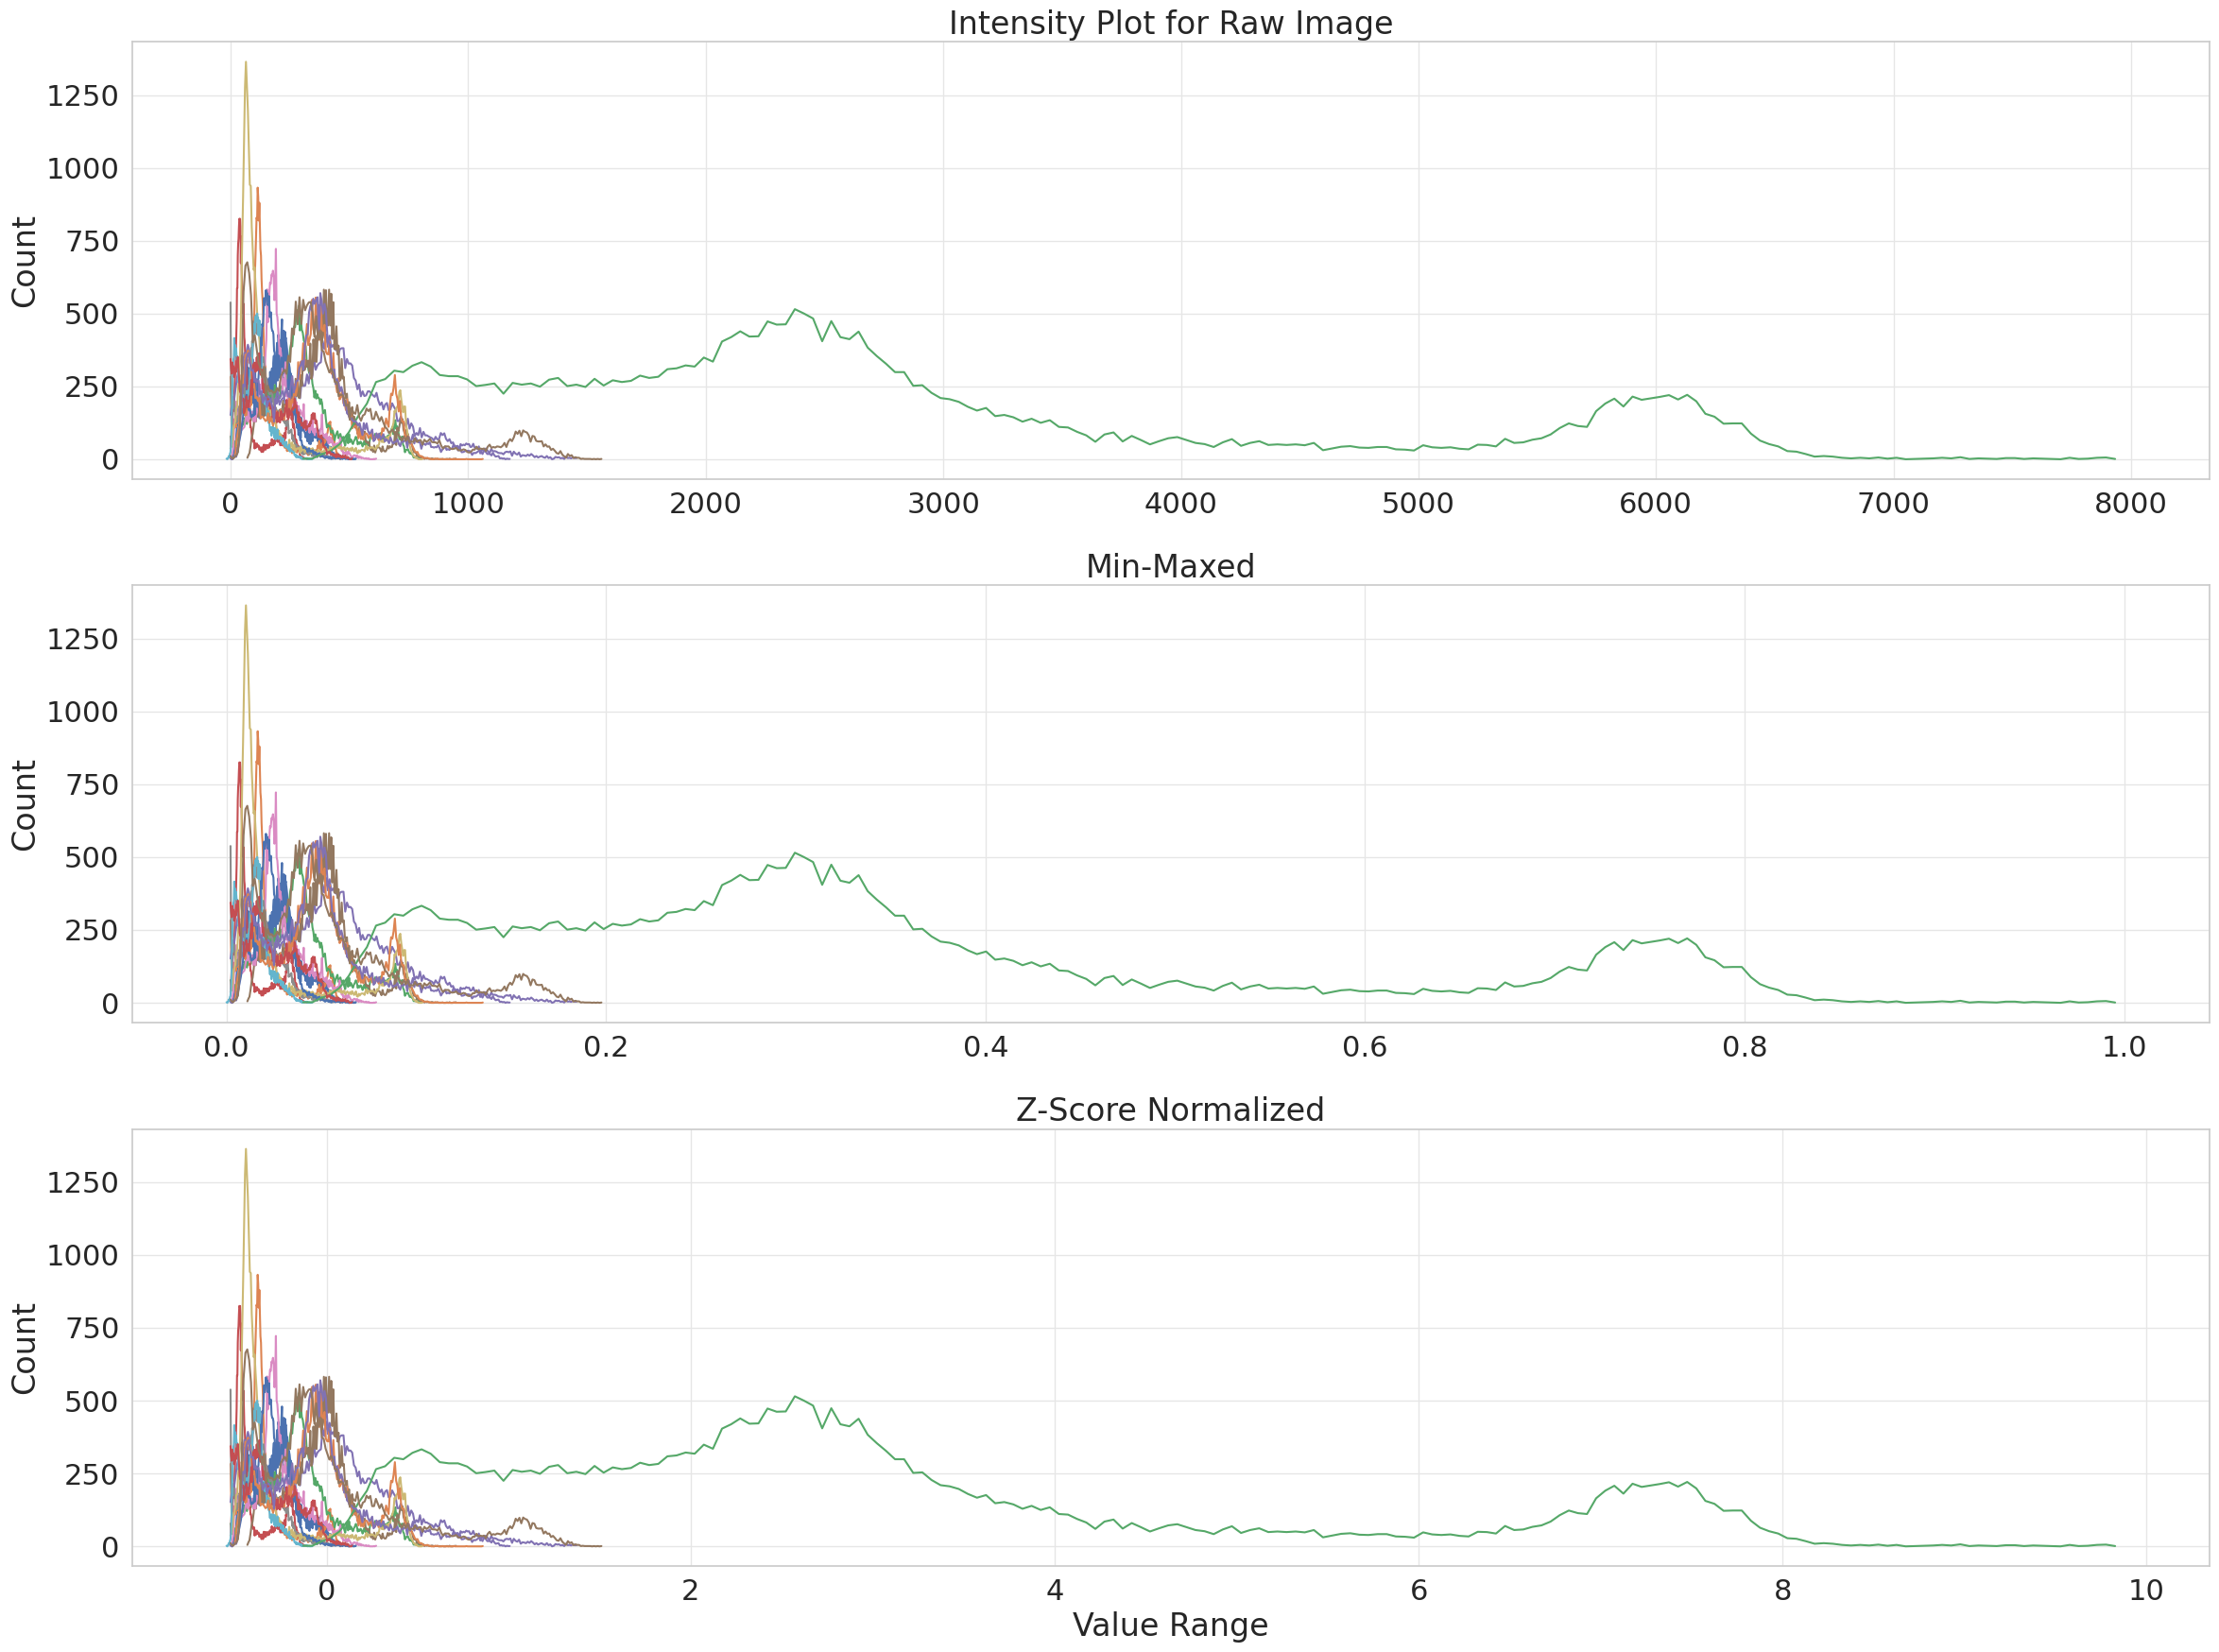

In [79]:
from intensity_normalization.plot.histogram import HistogramPlotter, plot_histogram

images = img.numpy()
maxmin = mmax.numpy()
norms = zimg.numpy()
flattened_data1 = images.reshape(16, -1)
flattened_data2 = mmax.reshape(16, -1)
flattened_data3 = zimg.reshape(16, -1)


# Create a figure with two subplots
fig, axs = plt.subplots(3, 1, figsize=(24, 18))  # Two subplots side by side

# Plot data1 on the first subplot
for i in range(16):
    hist, bins = np.histogram(flattened_data1[i], bins=200,)
    axs[0].plot(bins[:-1], hist, label=f'Line {i+1}')
# axs[0].set_xlabel('Value Range')
axs[0].set_ylabel('Count')
axs[0].set_title('Intensity Plot for Raw Image')
# axs[0].legend()

# Plot data2 on the second subplot
for i in range(16):
    hist, bins = np.histogram(flattened_data2[i], bins=200,)
    axs[1].plot(bins[:-1], hist, label=f'Line {i+1}')
# axs[1].set_xlabel('Value Range')
axs[1].set_ylabel('Count')
axs[1].set_title('Min-Maxed')
# axs[1].legend()

for i in range(16):
    hist, bins = np.histogram(flattened_data3[i], bins=200,)
    axs[2].plot(bins[:-1], hist, label=f'Line {i+1}')
axs[2].set_xlabel('Value Range')
axs[2].set_ylabel('Count')
axs[2].set_title('Z-Score Normalized')
# axs[1].legend()

# Layout so plots do not overlap
fig.tight_layout()

# Show the plot
plt.show()

In [73]:
print(np.percentile(images, 95))

640.5244628906248


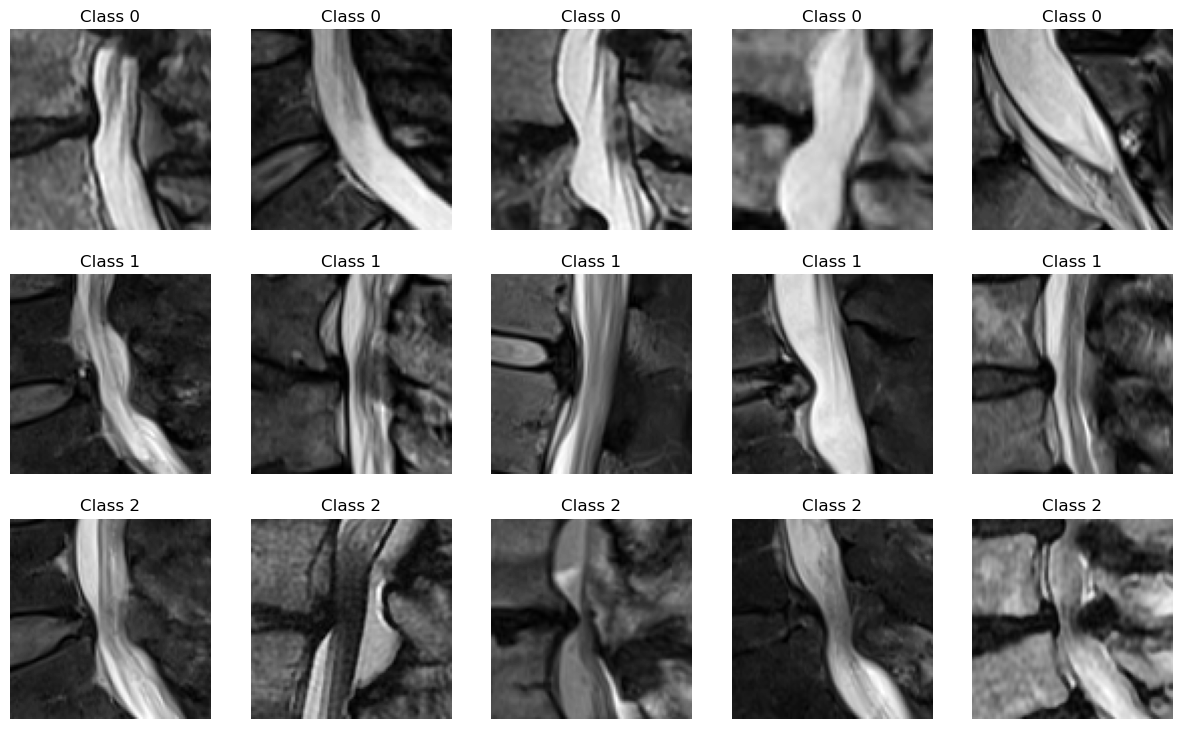

In [10]:
dataset = SpinalStenosisDataset(annotations_file, img_dir, transform=None)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)


fig, axs = plt.subplots(3, 5, figsize=(15, 9))

class_images = {0: [], 1: [], 2: []}

for image, label in dataloader:
    image = image.squeeze(0)  # remove batch dimension
    image = z_score_normalize(image)
    image = (image - image.min())/(image.max() - image.min())
    class_id = label.item()
    if len(class_images[class_id]) < 5:
        class_images[class_id].append((image, label))

    if all(len(images) == 5 for images in class_images.values()):
        break

for i, class_id in enumerate(class_images.keys()):
    for j, (image, label) in enumerate(class_images[class_id][:5]):
        axs[i, j].imshow(image[1, :, :].numpy(), cmap='gray')  # use only the first channel
        axs[i, j].set_title(f"Class {int(label.item())}")
        axs[i, j].axis('off')

plt.show()

#### Inception V3

In [10]:
model = models.inception_v3(weights='Inception_V3_Weights.DEFAULT')


# Replace the last layer with a new classification layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3) 

# Move the model to the device (GPU or CPU)
model.to(device)

def unfreeze_model(model, num_layers_to_unfreeze=5):
    for name, param in reversed(list(model.named_parameters())):
        if num_layers_to_unfreeze == 0:
            break
        param.requires_grad = True
        num_layers_to_unfreeze -= 1

unfreeze_model(model)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /home/mig/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:02<00:00, 46.1MB/s] 


#### DenseNet

In [9]:
model = models.densenet121(weights='DEFAULT')

num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 3) 

model.to(device)

def unfreeze_model(model, num_layers_to_unfreeze=5):
    for name, param in reversed(list(model.named_parameters())):
        if num_layers_to_unfreeze == 0:
            break
        param.requires_grad = True
        num_layers_to_unfreeze -= 1

unfreeze_model(model)

### SE Resnet

In [ ]:
Net = getattr(modelzoo, 'se_resnet101')
model = Net(num_classes=3)
model.to(device)
print("model loaded")

### SE ResNeXt

In [6]:
model = modelzoo.SEResNeXt(101)
model.fc = torch.nn.Linear(in_features=2048, out_features=3)
model.to(device)
print("model loaded")

model loaded


In [9]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=guess_weights.to(device))
# optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=3e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Create a dataloader instance
dataset = SpinalStenosisDataset(annotations_file, img_dir, transform=transform)
train_dataset, val_dataset = random_split(dataset, [int(0.8*len(dataset)), len(dataset) - int(0.8*len(dataset))])

# Create the data loaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=10, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=10, pin_memory=True)


/home/mig/anaconda3/envs/deeplearning/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [11]:
best_val_loss = float('inf')
patience = 30
no_improve = 0
train_list = []
val_list = []

# Train the model
for epoch in range(200):  
    model.train()
    loss_list = []
    for (images, labels) in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        # images = z_score_normalize(images)
        optimizer.zero_grad()
        outputs = model(images)
        # logits = outputs.logits
        logits= outputs
        loss = criterion(logits, labels.long())
        loss_list.append(loss.item())
        loss.backward()
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    model.eval()
    with torch.no_grad():
        total_correct = 0
        val_loss_list = []
        for images, labels in tqdm(val_dataloader):
            images = z_score_normalize(images)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.long())
            val_loss_list.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels.long()).sum().item()
        
        
        
        accuracy = total_correct / len(val_dataset)
        val_loss = sum(val_loss_list)/len(val_loss_list)
        train_epoch_loss = sum(loss_list)/len(loss_list)
        train_list.append(train_epoch_loss)
        val_list.append(val_loss)
        print(f"Epoch {epoch+1}, Train Loss: {train_epoch_loss}, Validation Loss:{val_loss}, Accuracy: {accuracy:.4f}")
        
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), 'weights/' + pathology +'_'+ model._get_name() + '_best_model.pth')
    else:
        no_improve += 1

    if no_improve >= patience:
        print("Early stopping!")
        break

  0%|          | 0/488 [00:00<?, ?it/s]

  0%|          | 0/488 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 88.00 MiB. GPU  has a total capacity of 23.46 GiB of which 77.06 MiB is free. Process 1125793 has 22.24 GiB memory in use. Including non-PyTorch memory, this process has 1.14 GiB memory in use. Of the allocated memory 886.37 MiB is allocated by PyTorch, and 69.63 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

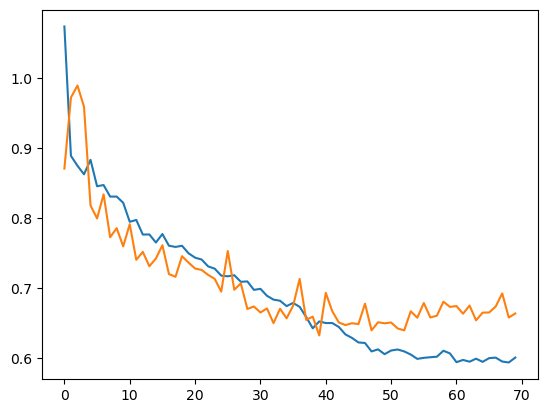

In [11]:
plt.plot(train_list)
plt.plot(val_list)

100%|██████████| 122/122 [00:11<00:00, 10.62it/s]
/home/mig/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mig/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mig/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

Accuracy: 0.0784
Precision: 0.3373
Recall: 0.3340
F1 Score: 0.0502
ROC AUC: 0.4822

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.01      0.02      1737
         1.0       0.07      0.99      0.13       138
         2.0       0.00      0.00      0.00        76

    accuracy                           0.08      1951
   macro avg       0.34      0.33      0.05      1951
weighted avg       0.84      0.08      0.03      1951


Confusion Matrix:
[[  16 1721    0]
 [   1  137    0]
 [   0   76    0]]


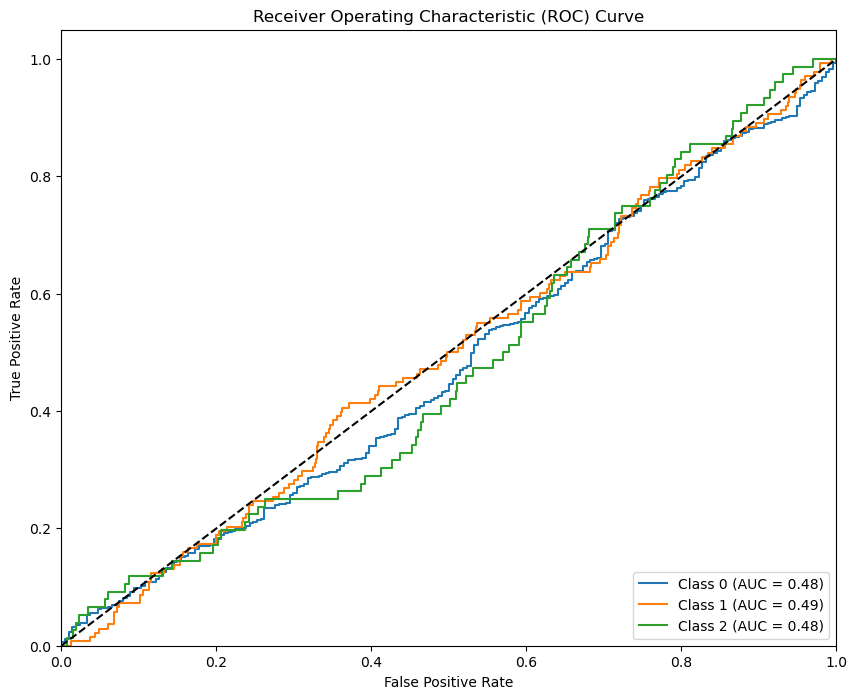

(0.07842132239876987,
 0.3373380375935276,
 0.33398830233702953,
 0.050161131974130836,
 0.48215752565647296)

In [23]:
def evaluate_model(model, dataloader, device, class_names=None):
    model.eval()
    total_preds = []
    total_labels = []
    total_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)

            total_preds.extend(preds.cpu().numpy())
            total_labels.extend(labels.cpu().numpy())
            total_probs.extend(probs.cpu().numpy())

    total_preds = np.array(total_preds)
    total_labels = np.array(total_labels)
    total_probs = np.array(total_probs)

    # Compute metrics
    accuracy = accuracy_score(total_labels, total_preds)
    precision = precision_score(total_labels, total_preds, average='macro')
    recall = recall_score(total_labels, total_preds, average='macro')
    f1 = f1_score(total_labels, total_preds, average='macro')
    
    # Compute ROC AUC
    n_classes = total_probs.shape[1]
    if n_classes > 2:  # Multi-class
        roc_auc = roc_auc_score(total_labels, total_probs, multi_class='ovr', average='macro')
    else:  # Binary
        roc_auc = roc_auc_score(total_labels, total_probs[:, 1])

    # Print metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print('\nClassification Report:')
    print(classification_report(total_labels, total_preds))
    print('\nConfusion Matrix:')
    print(confusion_matrix(total_labels, total_preds))

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    
    if n_classes == 2:
        fpr, tpr, _ = roc_curve(total_labels, total_probs[:, 1])
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    else:
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(total_labels == i, total_probs[:, i])
            class_roc_auc = roc_auc_score(total_labels == i, total_probs[:, i])
            class_name = class_names[i] if class_names else f'Class {i}'
            plt.plot(fpr, tpr, label=f'{class_name} (AUC = {class_roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return accuracy, precision, recall, f1, roc_auc

evaluate_model(model, val_dataloader, device)

In [20]:
# pathology = 'scs'
model.load_state_dict(torch.load('weights/'+pathology+'_'+ model._get_name() + '_best_model.pth'))

<All keys matched successfully>

100%|██████████| 122/122 [00:11<00:00, 10.59it/s]
/home/mig/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mig/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mig/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

Accuracy: 0.8795
Precision: 0.2932
Recall: 0.3333
F1 Score: 0.3120
ROC AUC: 0.5223

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      1716
         1.0       0.00      0.00      0.00       145
         2.0       0.00      0.00      0.00        90

    accuracy                           0.88      1951
   macro avg       0.29      0.33      0.31      1951
weighted avg       0.77      0.88      0.82      1951


Confusion Matrix:
[[1716    0    0]
 [ 145    0    0]
 [  90    0    0]]


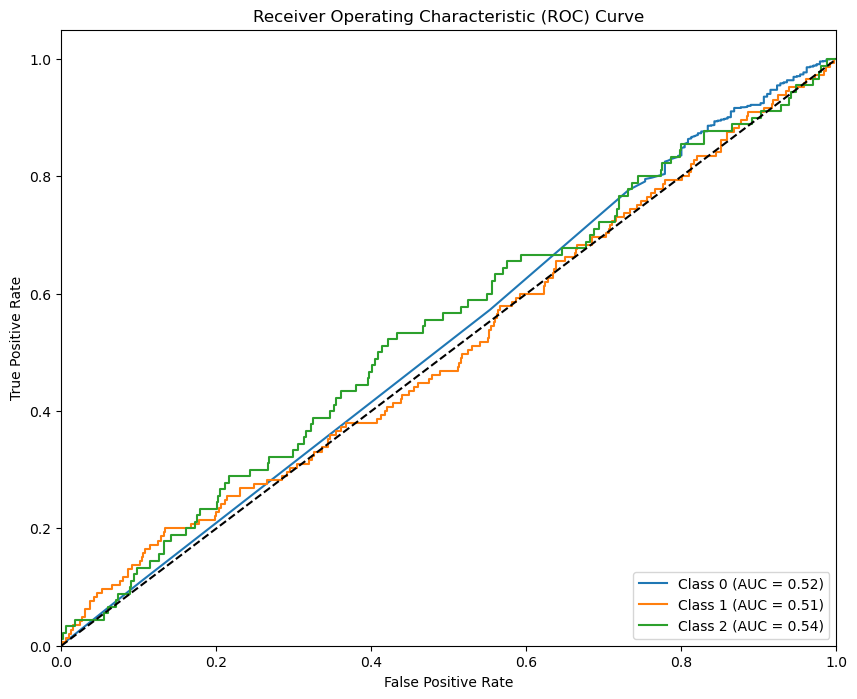

(0.8795489492567914,
 0.29318298308559715,
 0.3333333333333333,
 0.3119716389419144,
 0.5223049847171655)

In [21]:
evaluate_model(model, val_dataloader, device)

In [110]:
study_id = "44036939"
series_id = "3844393089"

df= pd.read_csv('../segmentation/preds/'+pathology+'_test.csv')
class_map = {0:'l1_l2', 1:'l2_l3', 2:'l3_l4', 3:'l4_l5', 4:'l5_s1'}
# side_map = {'R':'right', 'L':'left'}
df['class'] = df['class'].map(class_map)
# df['side'] = df['side'].map(side_map)
df

,class,confidence,x1,y1,x2,y2,instance
0,l1_l2,0.633444,289.420410,144.850800,334.196533,190.426727,10.0
1,l2_l3,0.724041,259.627716,201.028519,304.157654,244.825729,13.0
2,l3_l4,0.774434,236.169586,252.589432,278.171936,294.306183,15.0
3,l4_l5,0.796368,225.169022,305.790070,267.322968,347.698334,16.0
4,l5_s1,0.729765,233.832932,351.245422,279.951355,395.879639,15.0


In [285]:
def process_row(row):
    # open DICOM file
    instance = int(row['instance'])
    filepath = f"../test_images/{study_id}/{series_id}/{instance}.dcm"
    ds = pydicom.dcmread(filepath)

    # resize DICOM image to 512x512
    img = ds.pixel_array
    img = img.astype(np.float32)
    img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_CUBIC)
    
    img = np.array(img)

    # extract box from image using x and y values
    x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']
    box = img[int(y1)-30:int(y2)+30, int(x1)-30:int(x2)+30]
    plt.imshow(box, cmap='grey')

    box = torch.from_numpy(box).unsqueeze(0)  # Add channel dimension
    box = box.repeat(3, 1, 1)
    # print(box)
    # convert box to 1,3,299,299 tensor
    tensor = transforms.Compose([
        transforms.ToPILImage(), 
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        
    ])(box)
    tensor = tensor.unsqueeze(0)
    # pass tensor through model and get softmax output
    output = model(tensor.to(device))
    probs = torch.nn.functional.softmax(output, dim=1)

    # return probabilities as a numpy array
    return probs.cpu().detach().numpy()

# apply function to each row and store results
probs_list = []
for index, row in df.iterrows():
    probs = process_row(row)
    probs_list.append(probs.squeeze())

# create a new dataframe with probabilities
probs_df = pd.DataFrame(probs_list, columns=['normal_mild', 'moderate', 'severe'])

# create a new column with concatenated string
# probs_df['row_id'] = df.apply(lambda row: f"{study_id}_{row['side']}_neural_foraminal_narrowing_{row['class']}", axis=1)
probs_df['row_id'] = df.apply(lambda row: f"{study_id}_spinal_canal_stenosis_{row['class']}", axis=1)


# concatenate with original dataframe
result_df = pd.concat([probs_df.iloc[:,-1], probs_df.iloc[:,:-1]], axis=1)

print(result_df)

KeyError: 'instance'

In [64]:
sas_result = result_df.copy()

In [70]:
nfn_result = result_df.copy()

In [74]:
scs_result = result_df.copy()

In [77]:
mask = sas_result['row_id'].str.contains('left')
index = np.where(mask, 0, 1)
sas_result = sas_result.iloc[np.argsort(index)]
sas_result

,row_id,normal_mild,moderate,severe
1,44036939_left_subarticular_stenosis_l1_l2,0.908192,0.080835,0.010974
2,44036939_left_subarticular_stenosis_l2_l3,0.846546,0.133855,0.019599
7,44036939_left_subarticular_stenosis_l4_l5,0.913547,0.072165,0.014288
5,44036939_left_subarticular_stenosis_l3_l4,0.888951,0.094695,0.016354
8,44036939_left_subarticular_stenosis_l5_s1,0.892961,0.088895,0.018144
3,44036939_right_subarticular_stenosis_l2_l3,0.902902,0.084265,0.012834
4,44036939_right_subarticular_stenosis_l3_l4,0.939369,0.054374,0.006258
0,44036939_right_subarticular_stenosis_l1_l2,0.918459,0.071711,0.009830
6,44036939_right_subarticular_stenosis_l4_l5,0.854041,0.126545,0.019414
9,44036939_right_subarticular_stenosis_l5_s1,0.892937,0.089095,0.017968


In [79]:
df_submit = pd.concat([nfn_result, sas_result, scs_result])
df_submit = df_submit.sort_values('row_id')

In [81]:
df_submit.to_csv('submission.csv', index=False)